In [99]:
import pandas as pd
from sklearn.model_selection import learning_curve,train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer,make_column_selector
from sklearn.preprocessing import OneHotEncoder,StandardScaler
from sklearn.decomposition import PCA
from xgboost import XGBClassifier
import mlflow as ml
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter("ignore", category=UserWarning)

In [89]:
df = pd.read_csv('data.csv')

In [90]:
# df2 = df.loc[0:9999]
# df2

In [91]:
df.NewExist = df.NewExist.astype(str)
df.UrbanRural= df.UrbanRural.astype(str)
df.Real_estate = df.Real_estate.astype(str)
df.FranchiseCode = df.FranchiseCode.apply(lambda x: 1 if x ==1 else 0)
df.FranchiseCode = df.FranchiseCode.astype(str)
df.CreateJob


0         0
1         0
2         0
3         0
4         7
         ..
894956    0
894957    0
894958    0
894959    0
894960    0
Name: CreateJob, Length: 894961, dtype: int64

In [92]:
X = df[['UrbanRural','CreateJob','RetainedJob','NoEmp','Real_estate','GrAppv','Industry','Term','FranchiseCode','NewExist','State']]
y = df['MIS_Status']
X_1, X_2, y_1, y_2 = train_test_split(X, y,shuffle=True, train_size=0.015, random_state=42, stratify=y)

In [93]:
X_train, X_test, y_train, y_test = train_test_split(X_1, y_1,shuffle=True, train_size=0.8, random_state=42, stratify=y_1)

In [94]:
transformer = make_column_transformer(
    (OneHotEncoder(),make_column_selector(dtype_exclude=np.number)),
    (StandardScaler(),make_column_selector(dtype_include=np.number))
    )

In [95]:
xgb= make_pipeline(
        transformer,
        XGBClassifier(
            max_depth=10,
            learning_rate=0.1,
            n_estimators=100,
            gamma=50, 
            min_child_weight=0,
            subsample=0.8,
            colsample_bytree=0.8,
            reg_alpha=0.005
    )
)

# Entrainement de notre modèle en utilisant les paramètres par défaut 
xgb.fit(X_train,y_train)



Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fe5e8798c70>),
                                                 ('standardscaler',
                                                  StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fe5e8799cc0>)])),
                ('xgbclassifier',
                 XGBClassifier(base_score=None...
                               feature_types=None, gamma=50, gpu_id=None,
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None, learning_rate=0.1,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=10, max_leaves=None,
                               min_child_weight=0, missing=nan,
                               monotone_constraints=None, n_estimators=100,
                               n_jobs=None, num_parallel_tree=None,
                               predictor=None, random_state=None, ...))])

In [96]:
xgb.named_steps['xgbclassifier']

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=50, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=10, max_leaves=None,
              min_child_weight=0, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [97]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10739 entries, 235755 to 257676
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   UrbanRural     10739 non-null  object 
 1   CreateJob      10739 non-null  int64  
 2   RetainedJob    10739 non-null  int64  
 3   NoEmp          10739 non-null  int64  
 4   Real_estate    10739 non-null  object 
 5   GrAppv         10739 non-null  float64
 6   Industry       10739 non-null  object 
 7   Term           10739 non-null  int64  
 8   FranchiseCode  10739 non-null  object 
 9   NewExist       10739 non-null  object 
 10  State          10739 non-null  object 
dtypes: float64(1), int64(4), object(6)
memory usage: 1006.8+ KB


[ 859 2792 4725 6658 8591]


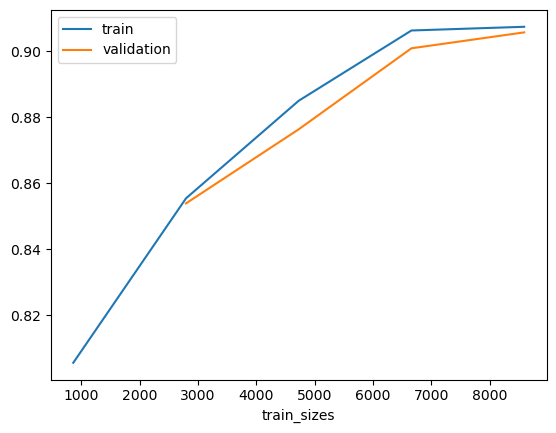

In [98]:
N, train_score, val_score = learning_curve(xgb, X_train, y_train,cv=5)
print(N)
plt.plot(N, train_score.mean(axis=1), label='train')
plt.plot(N, pd.DataFrame(val_score).mean(axis=1), label='validation')
plt.xlabel('train_sizes')
plt.legend()

In [102]:
a =make_column_selector(dtype_include=np.number)
a(X_train)

['CreateJob', 'RetainedJob', 'NoEmp', 'GrAppv', 'Term']

In [104]:
X_train_standard =StandardScaler().fit_transform(X_train[a(X_train)])


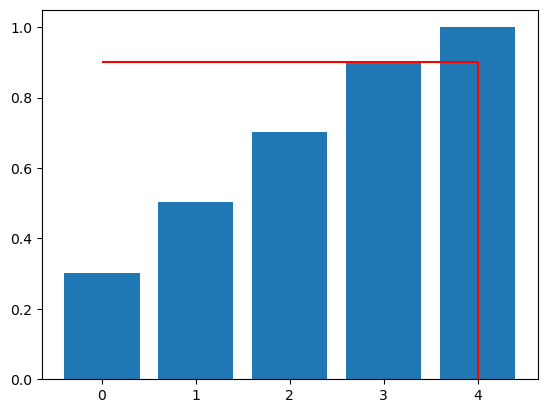

In [108]:
n_dims = X_train_standard.shape[1]
model = PCA(n_components=n_dims)
model.fit(X_train_standard)

variances = model.explained_variance_ratio_

meilleur_dims = np.argmax(np.cumsum(variances) > 0.90)

import matplotlib.pyplot as plt
plt.bar(range(n_dims), np.cumsum(variances))
plt.hlines(0.90, 0, meilleur_dims, colors='r')
plt.vlines(meilleur_dims, 0, 0.90, colors='r')